https://github.com/s6hebern/Python/blob/master/geospatial/legacy/s3netcdf2other.py

https://gis.stackexchange.com/questions/103116/map-project-a-raster-having-separate-latitude-and-longitude-raster-bands

https://gis.stackexchange.com/questions/273536/netcdf-with-separate-lat-lon-bands-to-geotiff-with-python-gdal

https://gis.stackexchange.com/questions/154339/unable-to-warp-hdf5-files

https://gis.stackexchange.com/questions/254729/warping-image-having-lat-lon-geolocation-array

https://gis.stackexchange.com/questions/276253/set-metadata-domain-with-gdal-python-bindings

https://gis.stackexchange.com/questions/259700/converting-sentinel-3-data-netcdf-to-geotiff

https://gdal.org/drivers/raster/vrt.html

https://gis.stackexchange.com/questions/134617/how-to-match-a-raster-netcdf-data-with-a-vector-layer-in-qgis

https://gis.stackexchange.com/questions/137331/georeferencing-uneven-irregularly-gridded-rasters-using-gdal



In [ ]:
import os
import sys
import shutil
import math
import subprocess as sub
from osgeo import gdal, osr
from netCDF4 import Dataset
from basic_functions.callCmd import callCmd


def calculateUtmZone(input):
    ds = gdal.Open(input, gdal.GA_ReadOnly)
    srs = osr.SpatialReference()
    srs.ImportFromWkt(ds.GetProjection())
    srs.AutoIdentifyEPSG()
    epsg = int(srs.GetAttrValue('AUTHORITY', 1))
    if epsg != 4326:
        raise AttributeError('Coordinate System is not WGS84 with EPSG 4326!')
    geotrans = ds.GetGeoTransform()
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    ds = None
    cent_x = geotrans[0] + geotrans[1] * (cols / 2)
    cent_y = geotrans[3] + geotrans[5] * (rows / 2)
    utm_zone_num = int(math.floor((cent_x + 180) / 6) + 1)
    utm_zone_hemi = 6 if cent_y >= 0 else 7
    utm_epsg = 32000 + utm_zone_hemi * 100 + utm_zone_num
    return utm_epsg


def s3netcdf2other(input_dir, output_image, instrument='OLCI', outformat='GTiff', to_utm=True, outres=300):
    tempdir = os.path.join(input_dir, 'tmp')
    if os.path.exists(tempdir):
        shutil.rmtree(tempdir)
    os.mkdir(tempdir)
    print('Retrieving coordinates...')
    if instrument == 'OLCI':
        BANDNAMES = ['Oa{0}_radiance'.format(str(i).zfill(2)) for i in range(1, 22)]  # range(1, 22)
        nc_coords = os.path.join(input_dir, 'geo_coordinates.nc')
        ds_nc = Dataset(nc_coords, 'r')
        coords = (ds_nc.variables['latitude'], ds_nc.variables['longitude'])
    elif instrument == 'SLSTR':
        BANDNAMES = ['S{0}_radiance_an'.format(str(i).zfill(1)) for i in range(1, 7)]  # range(1, 10)
        BANDNAMES = BANDNAMES + ['S{0}_BT_in'.format(str(i).zfill(1)) for i in range(7, 10)]  # range(1, 10)
        BANDNAMES = BANDNAMES + ['F{0}_BT_in'.format(str(i).zfill(1)) for i in range(1, 3)]  # range(1, 10)
        nc_coords = os.path.join(input_dir, 'geodetic_an.nc')
        ds_nc = Dataset(nc_coords, 'r')
        coords = (ds_nc.variables['latitude_an'], ds_nc.variables['longitude_an'])
    else:
        print('Wrong instrument indicator! Must be either "OLCI" or "SLSTR"!')
    lat_tif = os.path.join(tempdir, coords[0].name + '.tif')
    lon_tif = os.path.join(tempdir, coords[1].name + '.tif')
    rad_tifs = []
    nc_paths = [os.path.join(input_dir, band + '.nc') for band in BANDNAMES]
    # get lat/lon
    for v, var in enumerate(coords):
        nodata = var._FillValue
        scale = var.scale_factor
        var_vrt = os.path.join(tempdir, var.name + '.vrt')
        var_tif = os.path.join(tempdir, var.name + '.tif')
        cmd = ['gdalbuildvrt', '-sd', str(1 + var._varid), '-separate', '-overwrite', var_vrt, nc_coords]
        sub.call(cmd)
        # edit vrt
        with open(var_vrt, 'r') as f:
            xml = f.readlines()
        for line in xml:
            if '<VRTRasterBand ' in line:
                head_index = xml.index(line) + 1
            if '<DstRect xOff' in line:
                tail_index = xml.index(line) + 1
        xml.insert(head_index, '    <NoDataValue>{nd}</NoDataValue>\n'.format(nd=nodata))
        xml.insert(head_index + 1, '    <Scale>{sc}</Scale>\n'.format(sc=scale))
        tail_index = tail_index + 2
        xml.insert(tail_index, '      <NODATA>{nd}</NODATA>\n'.format(nd=nodata))
        xml.insert(tail_index + 2, '    <Offset>0.0</Offset>\n')
        xml.insert(tail_index + 3, '    <Scale>{sc}</Scale>\n'.format(sc=scale))
        xml = [line.replace('="Int32', '="Float32') for line in xml]
        with open(var_vrt, 'w') as f:
            f.writelines(xml)
        # write to temporary tif
        cmd = ['gdal_translate', '-unscale', var_vrt, var_tif]
        sub.call(cmd)
    ds_nc.close()
    # single bands to vrt, then to tif
    print('Converting all {n} bands...'.format(n=len(BANDNAMES)))
    for n, nc in enumerate(nc_paths):
        print('\t... BAND {b}'.format(b=n+1))
        ds_nc = Dataset(nc, 'r')
        var = ds_nc.variables[os.path.basename(nc)[:-3]]
        nodata = var._FillValue
        offset = var.add_offset
        rows = var.shape[0]
        scale = var.scale_factor
        ds_nc.close()
        data_vrt = os.path.join(tempdir, 'data.vrt')
        data_vrt_tif = data_vrt.replace('.vrt', '.tif')
        out_vrt = os.path.join(tempdir, os.path.basename(nc)[:-3] + '.vrt')
        out_tif = out_vrt.replace('.vrt', '.tif')
        if instrument == 'OLCI':
            cmd = ['gdalbuildvrt', '-sd', '1', '-separate', '-overwrite', data_vrt, nc]
        else:
            if os.path.basename(nc).endswith('BT_in.nc'):
                cmd = ['gdalbuildvrt', '-sd', '1', '-separate', '-overwrite', data_vrt, nc]
            else:
                cmd = ['gdalbuildvrt', '-sd', '3', '-separate', '-overwrite', data_vrt, nc]
        sub.call(cmd)
        # edit vrt
        with open(data_vrt, 'r') as f:
            xml = f.readlines()
        for line in xml:
            if '<VRTRasterBand ' in line:
                head_index = xml.index(line)
            if '<DstRect xOff' in line:
                tail_index = xml.index(line) + 1
        xml[head_index] = '  <VRTRasterBand dataType="Float32" band="1">\n'
        xml.insert(head_index + 1, '    <NoDataValue>{nd}</NoDataValue>\n'.format(nd=nodata))
        xml[head_index + 2] = '    <ComplexSource>\n'
        xml[head_index + 5] = xml[head_index + 5].replace('DataType="UInt16"', 'DataType="Float32"')
        tail_index = tail_index + 1
        xml.insert(tail_index, '      <NODATA>{nd}</NODATA>\n'.format(nd=nodata))
        xml[tail_index + 1] = '    </ComplexSource>\n'
        xml.insert(tail_index + 2, '    <Offset>{off}</Offset>\n'.format(off=offset))
        xml.insert(tail_index + 3, '    <Scale>{sc}</Scale>\n'.format(sc=scale))
        with open(data_vrt, 'w') as f:
            f.writelines(xml)
        # write to temporary tif, then build a new vrt
        cmd = ['gdal_translate', '-unscale', data_vrt, data_vrt_tif]
        sub.call(cmd)
        # update GeoTransform
        ds = gdal.Open(data_vrt_tif, gdal.GA_Update)
        ds.SetGeoTransform((0.0, 1.0, 0.0, float(rows), 0.0, -1.0))
        ds.FlushCache()
        # build new vrt
        cmd = ['gdalbuildvrt', '-sd', '1', '-separate', '-overwrite', out_vrt, data_vrt_tif]
        sub.call(cmd)
        # edit vrt
        with open(out_vrt, 'r') as f:
            xml = f.readlines()
        for line in xml:
            if '<VRTRasterBand ' in line:
                head_index = xml.index(line)
                break
        xml[head_index] = '  <VRTRasterBand dataType="Float32" band="1">\n'
        xml.insert(-1, '''  <metadata domain="GEOLOCATION">
    <mdi key="X_DATASET">{lon}</mdi>
    <mdi key="X_BAND">1</mdi>
    <mdi key="Y_DATASET">{lat}</mdi>
    <mdi key="Y_BAND">1</mdi>
    <mdi key="PIXEL_OFFSET">0</mdi>
    <mdi key="LINE_OFFSET">0</mdi>
    <mdi key="PIXEL_STEP">1</mdi>
    <mdi key="LINE_STEP">1</mdi>
  </metadata>\n'''.format(lon=lon_tif, lat=lat_tif))
        for line in xml:
            if os.sep in line:
                xml[xml.index(line)] = line.replace(os.sep, '/')
        with open(out_vrt, 'w') as f:
            f.writelines(xml)
        # convert to tif
        cmd = ['gdalwarp', '-t_srs', 'epsg:4326', '-geoloc', '-srcnodata', str(nodata), '-dstnodata', '-9999', out_vrt,
               out_tif]
        sub.call(cmd)
        # remove temp files safely
        os.remove(out_vrt)
        ds = gdal.Open(data_vrt_tif, gdal.GA_ReadOnly)
        ds = None
        os.remove(data_vrt_tif)
        rad_tifs.append(out_tif)
    # stack together
    print('Stacking bands...')
    if 'win' in sys.platform.lower():
        gdal_path = r'c:\Program Files\GDAL'
    else:
        gdal_path = r'/usr/bin'
    gdal_merge = os.path.join(gdal_path, 'gdal_merge.py')
    stack = os.path.join(tempdir, 'stack.tif')
    cmd = ['python', gdal_merge, '-separate', '-n', '-9999', '-o', stack]
    for r in rad_tifs:
        cmd.append(r)
    if os.path.exists(output_image):
        drv = gdal.GetDriverByName(outformat)
        drv.Delete(output_image)
    sub.call(cmd)
    if to_utm is True:
        epsg = calculateUtmZone(stack)
        print('Reprojecting to UTM (EPSG: {e})'.format(e=epsg))
        cmd = ['gdalwarp', '-of', outformat, '-srcnodata', '-9999', '-dstnodata', '-9999', '-overwrite',
               '-t_srs', 'epsg:{e}'.format(e=str(epsg)), '-tr', str(outres), str(outres), stack, output_image]
        sub.call(cmd)
    else:
        if not outformat == 'GTiff':
            print('Converting to {of}...'.format(of=outformat))
            cmd = ['gdal_translate', '-of', outformat, '-a_nodata', '-9999', stack, output_image]
            if outformat == 'ENVI':
                cmd.append('-co')
                cmd.append('interleave=bil')
            elif outformat == 'GTiff':
                cmd.append('-co')
                cmd.append('compress=lzw')
                sub.call(cmd)
    print('Cleaning up...')
    shutil.rmtree(tempdir)
    print('Done!')


if __name__ == '__main__':
    indir = r'd:\working\testing\s3\S3A_OL_1_EFR____20180402T093229_20180402T093529_20180403T155138_0179_029_307_1980_MAR_O_NT_002.SEN3'
    instru = 'OLCI'
    out = os.path.join(os.path.dirname(indir), 'OLCI')
    s3netcdf2other(indir, out, instrument=instru, to_utm=True)
    indir = r'd:\working\testing\s3\S3A_SL_1_RBT____20180402T093229_20180402T093529_20180403T170539_0180_029_307_1980_MAR_O_NT_002.SEN3'
    instru = 'SLSTR'
    out = os.path.join(os.path.dirname(indir), 'SLSTR')
    s3netcdf2other(indir, out, instrument=instru, to_utm=True)

In [2]:
import waterdetect
from pathlib import Path
import gdal

In [6]:
path=Path('D:/Images/Download/GRS/S2A_MSIl2grs_20160921T143742_N0204_R096_T20LKQ_20160921T143741_jirau_GRS.nc')
path.exists()

True

In [129]:
ds = gdal.Open(str(path))
subds = ds.GetSubDatasets()
subds[0][0]

'NETCDF:"D:\\Images\\Download\\GRS\\S2A_MSIl2grs_20160921T143742_N0204_R096_T20LKQ_20160921T143741_jirau_GRS.nc":flags'

In [132]:
ds.GetGeoTransform()

(0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

In [12]:
ds.GetDescription()

'D:\\Images\\Download\\GRS\\S2A_MSIl2grs_20160921T143742_N0204_R096_T20LKQ_20160921T143741_jirau_GRS.nc'

In [13]:
ds.GetMetadata()

{'NC_GLOBAL#auto_grouping': 'Rrs:Rrs_g_',
 'NC_GLOBAL#Conventions': 'CF-1.4',
 'NC_GLOBAL#metadata_profile': 'beam',
 'NC_GLOBAL#metadata_version': '0.5',
 'NC_GLOBAL#product_type': 'L2grs',
 'NC_GLOBAL#start_date': '21-SEP-2016 14:37:42.026000',
 'NC_GLOBAL#stop_date': '21-SEP-2016 14:37:42.026000',
 'NC_GLOBAL#TileSize': '2048:2048'}

In [16]:
ds.GetLayerByIndex(2)

In [17]:
ds.GetRasterBand(1)

In [32]:
s = 'NETCDF:"'+str(path)+'"'
s

'NETCDF:"D:\\Images\\Download\\GRS\\S2A_MSIl2grs_20160921T143742_N0204_R096_T20LKQ_20160921T143741_jirau_GRS.nc"'

In [133]:
ds = gdal.Open('NETCDF:'+str(path)+':flags')

In [134]:
ds.RasterCount

1

In [136]:
ds.GetGeoTransform()

(0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

In [43]:
ds.ReadAsArray()

array([[ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [36, 36, 36, ...,  4,  4,  4],
       [36, 36, 36, ...,  4,  4,  4],
       [36, 36, 36, ...,  4,  4,  4]], dtype=uint8)

In [57]:
subds[10][1]

'[5490x5490] Rrs_g_B11 (32-bit floating-point)'

In [59]:
b = gdal.Open(subds[10][0])
arr = b.ReadAsArray()

In [61]:
import matplotlib.pyplot as plt
plt.imshow(arr)

In [ ]:
subds = ds.GetSubDatasets()
subds

In [62]:
from scipy.io import netcdf

In [64]:
f = netcdf.netcdf_file(str(path))

TypeError: Error: D:\Images\Download\GRS\S2A_MSIl2grs_20160921T143742_N0204_R096_T20LKQ_20160921T143741_jirau_GRS.nc is not a valid NetCDF 3 file

In [66]:
import netCDF4 as nc

In [ ]:
ds.variables['metadata']

In [143]:
ds = nc.Dataset(str(path))

In [138]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.4
    TileSize: 2048:2048
    product_type: L2grs
    metadata_profile: beam
    metadata_version: 0.5
    auto_grouping: Rrs:Rrs_g_
    start_date: 21-SEP-2016 14:37:42.026000
    stop_date: 21-SEP-2016 14:37:42.026000
    dimensions(sizes): y(5490), x(5490)
    variables(dimensions): int8 metadata(), int8 flags(y,x), float32 Rrs_g_B1(y,x), float32 Rrs_g_B2(y,x), float32 Rrs_g_B3(y,x), float32 Rrs_g_B4(y,x), float32 Rrs_g_B5(y,x), float32 Rrs_g_B6(y,x), float32 Rrs_g_B7(y,x), float32 Rrs_g_B8(y,x), float32 Rrs_g_B8A(y,x), float32 Rrs_g_B11(y,x), float32 Rrs_g_B12(y,x), float32 Rrs_B1(y,x), float32 Rrs_B2(y,x), float32 Rrs_B3(y,x), float32 Rrs_B4(y,x), float32 Rrs_B5(y,x), float32 Rrs_B6(y,x), float32 Rrs_B7(y,x), float32 Rrs_B8(y,x), float32 Rrs_B8A(y,x), float32 Rrs_B11(y,x), float32 Rrs_B12(y,x), float32 BRDFg(y,x), float32 aot550(y,x), float32 SZA(y,x), float32 VZA(y,

In [160]:
var = ds['Rrs_g_B6']
var

<class 'netCDF4._netCDF4.Variable'>
float32 Rrs_g_B6(y, x)
    long_name: Water-leaving plus sunglint remote sensing reflectance (Rrs + Lg/F0) in sr-1 at B6
    _FillValue: nan
    coordinates: lat lon
    bandwidth: 40.0
    wavelength: 740.4838
    valid_pixel_expression: mask_nodata == 0 && mask_ndwi == 0
unlimited dimensions: 
current shape = (5490, 5490)
filling on

In [158]:
var = ds['Rrs_B6']

In [161]:
ds.variables['Rrs_g_B6'].data

AttributeError: NetCDF: Attribute not found

In [162]:
marr = var[:]

In [98]:
plt.imshow(marr.data)

In [90]:
import numpy as np

In [100]:
np.count_nonzero(marr.data > 0)

D:\Programs\anaconda\envs\fastai2_v2\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


477527

In [115]:
img = np.where(marr.data > 0, marr.data, -1)

D:\Programs\anaconda\envs\fastai2_v2\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [163]:
marr.data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

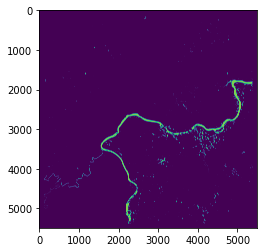

In [164]:
plt.imshow(img)

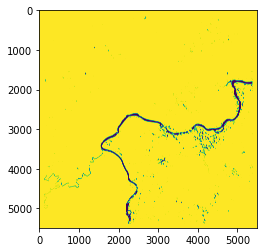

In [125]:
plt.imshow(marr.mask)

In [106]:
%matplotlib inline

In [124]:
marr.mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [121]:
np.nan

nan

In [127]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.4
    TileSize: 2048:2048
    product_type: L2grs
    metadata_profile: beam
    metadata_version: 0.5
    auto_grouping: Rrs:Rrs_g_
    start_date: 21-SEP-2016 14:37:42.026000
    stop_date: 21-SEP-2016 14:37:42.026000
    dimensions(sizes): y(5490), x(5490)
    variables(dimensions): int8 metadata(), int8 flags(y,x), float32 Rrs_g_B1(y,x), float32 Rrs_g_B2(y,x), float32 Rrs_g_B3(y,x), float32 Rrs_g_B4(y,x), float32 Rrs_g_B5(y,x), float32 Rrs_g_B6(y,x), float32 Rrs_g_B7(y,x), float32 Rrs_g_B8(y,x), float32 Rrs_g_B8A(y,x), float32 Rrs_g_B11(y,x), float32 Rrs_g_B12(y,x), float32 Rrs_B1(y,x), float32 Rrs_B2(y,x), float32 Rrs_B3(y,x), float32 Rrs_B4(y,x), float32 Rrs_B5(y,x), float32 Rrs_B6(y,x), float32 Rrs_B7(y,x), float32 Rrs_B8(y,x), float32 Rrs_B8A(y,x), float32 Rrs_B11(y,x), float32 Rrs_B12(y,x), float32 BRDFg(y,x), float32 aot550(y,x), float32 SZA(y,x), float32 VZA(y,

In [141]:
ds.product_type

'L2grs'

# Sentinel 3

In [3]:
path=Path('D:\Images\Download\Sentinel3\S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3/')
path.exists()

True

In [4]:
ds = gdal.Open(str(path/'Oa01_reflectance.nc'))

subds = ds.GetSubDatasets()[0][0]
band = gdal.Open(subds)
band.RasterCount

1

In [5]:
arr = band.ReadAsArray()

In [6]:
ds

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000018916A37CF0> >

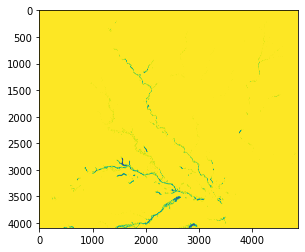

In [185]:
plt.imshow(arr)

In [186]:
srcband = band.GetRasterBand(1)

In [189]:
srcband.GetOffset()

-0.20000000298023224

In [190]:
srcband.GetMetadata_Dict()

{'add_offset': '-0.2',
 'long_name': 'Reflectance for OLCI acquisition band Oa01',
 'NETCDF_VARNAME': 'Oa01_reflectance',
 'scale_factor': '1.8311106e-05',
 '_FillValue': '65535'}

In [192]:
srcband.ComputeRasterMinMax()

(0.0, 23949.0)

In [193]:
ds = nc.Dataset(str(path))

In [197]:
ds.variables

OrderedDict([('Oa01_reflectance',
              <class 'netCDF4._netCDF4.Variable'>
              uint16 Oa01_reflectance(rows, columns)
                  _FillValue: 65535
                  add_offset: -0.2
                  long_name: Reflectance for OLCI acquisition band Oa01
                  scale_factor: 1.8311106e-05
              unlimited dimensions: 
              current shape = (4091, 4865)
              filling on),
             ('Oa01_reflectance_err',
              <class 'netCDF4._netCDF4.Variable'>
              uint16 Oa01_reflectance_err(rows, columns)
                  _FillValue: 65535
                  add_offset: -0.2
                  long_name: Error estimates for OLCI acquisition band Oa01
                  scale_factor: 1.8311106e-05
              unlimited dimensions: 
              current shape = (4091, 4865)
              filling on)])

In [198]:
gdal.WarpOptions()

(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x0000022B84AD45D0> >,
 None,
 None)

In [201]:
ds = nc.Dataset(str(path/'geo_coordinates.nc'))

In [224]:
arr = ds['latitude'][:]

In [225]:
arr

masked_array(
  data=[[ -0.127486,  -0.128023,  -0.128561, ...,  -2.720638,  -2.721164,
          -2.72169 ],
        [ -0.130057,  -0.130594,  -0.131132, ...,  -2.723237,  -2.723763,
          -2.724288],
        [ -0.132628,  -0.133165,  -0.133703, ...,  -2.725835,  -2.726361,
          -2.726887],
        ...,
        [-10.614315, -10.614923, -10.615531, ..., -13.335907, -13.336415,
         -13.336923],
        [-10.616874, -10.617482, -10.61809 , ..., -13.338502, -13.339009,
         -13.339517],
        [-10.619433, -10.620041, -10.620649, ..., -13.341096, -13.341604,
         -13.342112]],
  mask=False,
  fill_value=1e+20)

In [226]:
diff = arr - np.roll(arr, -1, axis=0)

In [227]:
diff.mean(axis=1)

masked_array(data=[ 2.59410421e-03,  2.59410031e-03,  2.59278705e-03, ...,
                    2.58581686e-03,  2.58493875e-03, -1.05926628e+01],
             mask=False,
       fill_value=1e+20)

In [234]:
band.GetMetadata()

{'NC_GLOBAL#absolute_orbit_number': '19347',
 'NC_GLOBAL#ac_subsampling_factor': '64',
 'NC_GLOBAL#al_subsampling_factor': '1',
 'NC_GLOBAL#comment': ' ',
 'NC_GLOBAL#contact': 'ops@eumetsat.int',
 'NC_GLOBAL#creation_time': '2019-11-24T13:45:08Z',
 'NC_GLOBAL#history': '  2019-11-24T13:45:08Z: PUGCoreProcessor /data/ipf-s3/workdir61/603967849/JobOrder.603967849.xml',
 'NC_GLOBAL#institution': 'MAR',
 'NC_GLOBAL#netCDF_version': '4.2 of Jul  5 2012 17:07:43 $',
 'NC_GLOBAL#product_name': 'S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3',
 'NC_GLOBAL#references': 'S3IPF PDS 004.3 - i2r2 - Product Data Format Specification - OLCI Level 2 Marine, S3IPF PDS 002 - i1r7 - Product Data Format Specification - Product Structures, S3IPF DPM 008 - i1r3 - Detailed Processing Model - OLCI Level 2',
 'NC_GLOBAL#resolution': '[ 270 294 ]',
 'NC_GLOBAL#source': 'IPF-OL-2 06.13',
 'NC_GLOBAL#start_time': '2019-11-04T13:50:01.882566Z',
 'NC_GLOBAL#stop

In [236]:
band.SetMetadataItem??

Signature: band.SetMetadataItem(*args)
Source:   
    def SetMetadataItem(self, *args):
        """SetMetadataItem(MajorObject self, char const * pszName, char const * pszValue, char const * pszDomain) -> CPLErr"""
        return _gdal.MajorObject_SetMetadataItem(self, *args)
File:      d:\programs\anaconda\envs\fastai2_v2\lib\site-packages\osgeo\gdal.py
Type:      method


In [237]:
band.SetSpatialRef?

Signature: band.SetSpatialRef(*args)
Docstring: SetSpatialRef(Dataset self, SpatialReference srs)
File:      d:\programs\anaconda\envs\fastai2_v2\lib\site-packages\osgeo\gdal.py
Type:      method


In [239]:
band.GetMetadata()

{'NC_GLOBAL#absolute_orbit_number': '19347',
 'NC_GLOBAL#ac_subsampling_factor': '64',
 'NC_GLOBAL#al_subsampling_factor': '1',
 'NC_GLOBAL#comment': ' ',
 'NC_GLOBAL#contact': 'ops@eumetsat.int',
 'NC_GLOBAL#creation_time': '2019-11-24T13:45:08Z',
 'NC_GLOBAL#history': '  2019-11-24T13:45:08Z: PUGCoreProcessor /data/ipf-s3/workdir61/603967849/JobOrder.603967849.xml',
 'NC_GLOBAL#institution': 'MAR',
 'NC_GLOBAL#netCDF_version': '4.2 of Jul  5 2012 17:07:43 $',
 'NC_GLOBAL#product_name': 'S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3',
 'NC_GLOBAL#references': 'S3IPF PDS 004.3 - i2r2 - Product Data Format Specification - OLCI Level 2 Marine, S3IPF PDS 002 - i1r7 - Product Data Format Specification - Product Structures, S3IPF DPM 008 - i1r3 - Detailed Processing Model - OLCI Level 2',
 'NC_GLOBAL#resolution': '[ 270 294 ]',
 'NC_GLOBAL#source': 'IPF-OL-2 06.13',
 'NC_GLOBAL#start_time': '2019-11-04T13:50:01.882566Z',
 'NC_GLOBAL#stop

In [249]:
ds.SetMetadataItem('X_BAND', '1', 'GEOLOCATION')
ds.SetMetadataItem('y_BAND', '1', 'GEOLOCATION')


0

In [250]:
ds.GetMetadata()

{'NC_GLOBAL#absolute_orbit_number': '19347',
 'NC_GLOBAL#ac_subsampling_factor': '64',
 'NC_GLOBAL#al_subsampling_factor': '1',
 'NC_GLOBAL#comment': ' ',
 'NC_GLOBAL#contact': 'ops@eumetsat.int',
 'NC_GLOBAL#creation_time': '2019-11-24T13:45:08Z',
 'NC_GLOBAL#history': '  2019-11-24T13:45:08Z: PUGCoreProcessor /data/ipf-s3/workdir61/603967849/JobOrder.603967849.xml',
 'NC_GLOBAL#institution': 'MAR',
 'NC_GLOBAL#netCDF_version': '4.2 of Jul  5 2012 17:07:43 $',
 'NC_GLOBAL#product_name': 'S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3',
 'NC_GLOBAL#references': 'S3IPF PDS 004.3 - i2r2 - Product Data Format Specification - OLCI Level 2 Marine, S3IPF PDS 002 - i1r7 - Product Data Format Specification - Product Structures, S3IPF DPM 008 - i1r3 - Detailed Processing Model - OLCI Level 2',
 'NC_GLOBAL#resolution': '[ 270 294 ]',
 'NC_GLOBAL#source': 'IPF-OL-2 06.13',
 'NC_GLOBAL#start_time': '2019-11-04T13:50:01.882566Z',
 'NC_GLOBAL#stop

In [ ]:
gdal.BuildVRT('bar', ds)

In [10]:
ds.SetMetadata({"X_BAND": "1" }, "GEOLOCATION")

0

In [11]:
ds.GetMetadata()

{'NC_GLOBAL#absolute_orbit_number': '19347',
 'NC_GLOBAL#ac_subsampling_factor': '64',
 'NC_GLOBAL#al_subsampling_factor': '1',
 'NC_GLOBAL#comment': ' ',
 'NC_GLOBAL#contact': 'ops@eumetsat.int',
 'NC_GLOBAL#creation_time': '2019-11-24T13:45:08Z',
 'NC_GLOBAL#history': '  2019-11-24T13:45:08Z: PUGCoreProcessor /data/ipf-s3/workdir61/603967849/JobOrder.603967849.xml',
 'NC_GLOBAL#institution': 'MAR',
 'NC_GLOBAL#netCDF_version': '4.2 of Jul  5 2012 17:07:43 $',
 'NC_GLOBAL#product_name': 'S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3',
 'NC_GLOBAL#references': 'S3IPF PDS 004.3 - i2r2 - Product Data Format Specification - OLCI Level 2 Marine, S3IPF PDS 002 - i1r7 - Product Data Format Specification - Product Structures, S3IPF DPM 008 - i1r3 - Detailed Processing Model - OLCI Level 2',
 'NC_GLOBAL#resolution': '[ 270 294 ]',
 'NC_GLOBAL#source': 'IPF-OL-2 06.13',
 'NC_GLOBAL#start_time': '2019-11-04T13:50:01.882566Z',
 'NC_GLOBAL#stop

In [14]:
dtype = gdal.GDT_Float32
cols = 100
rows = 100

driver = gdal.GetDriverByName('GTiff')
out_raster = driver.Create('D:/temp/temp_raster.tif', cols, rows, 1, dtype, options=['COMPRESS=PACKBITS'])

In [18]:
out_raster.SetMetadata({"X_BAND": "1" }, "GEOLOCATION")

0

In [17]:
out_raster.GetMetadata()

{}

In [19]:
out_raster.SetMetadataItem('teste', '3', 'eee')

0

In [42]:
ds = gdal.Open('D:/Images/Download/France-MAJA/SENTINEL2B_20190224-103835-289_L2A_T31TGK_C_V1-0/SENTINEL2B_20190224-103835-289_L2A_T31TGK_C_V1-0_FRE_B12.tif')

In [43]:
ds.GetMetadata()

{'AREA_OR_POINT': 'Area',
 'gml.root-instance': '<?xml version="1.0" encoding="UTF-8" standalone="no" ?>\n<gml:FeatureCollection xmlns:gml="http://www.opengis.net/gml" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.opengeospatial.net/gml http://schemas.opengis.net/gml/3.1.1/profiles/gmlJP2Profile/1.0.0/gmlJP2Profile.xsd">\n\n  <gml:boundedBy>\n    <gml:Null>withheld</gml:Null>\n  </gml:boundedBy>\n\n  <gml:featureMember>\n    <gml:FeatureCollection>\n      <gml:featureMember>\n        <gml:RectifiedGridCoverage dimension="2" gml:id="RGC0001">\n          <gml:rectifiedGridDomain>\n            <gml:RectifiedGrid dimension="2">\n              <gml:limits>\n                <gml:GridEnvelope>\n                  <gml:low>1 1</gml:low>\n                  <gml:high>5490 5490</gml:high>\n                </gml:GridEnvelope>\n              </gml:limits>\n              <gml:axisName>x</gml:axisName>\n              <gml:axisName>y</gml:axisName>\n              

In [25]:
ds.GetMetadata()

{'AREA_OR_POINT': 'Area',
 'gml.root-instance': '<?xml version="1.0" encoding="UTF-8" standalone="no" ?>\n<gml:FeatureCollection xmlns:gml="http://www.opengis.net/gml" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.opengeospatial.net/gml http://schemas.opengis.net/gml/3.1.1/profiles/gmlJP2Profile/1.0.0/gmlJP2Profile.xsd">\n\n  <gml:boundedBy>\n    <gml:Null>withheld</gml:Null>\n  </gml:boundedBy>\n\n  <gml:featureMember>\n    <gml:FeatureCollection>\n      <gml:featureMember>\n        <gml:RectifiedGridCoverage dimension="2" gml:id="RGC0001">\n          <gml:rectifiedGridDomain>\n            <gml:RectifiedGrid dimension="2">\n              <gml:limits>\n                <gml:GridEnvelope>\n                  <gml:low>1 1</gml:low>\n                  <gml:high>5490 5490</gml:high>\n                </gml:GridEnvelope>\n              </gml:limits>\n              <gml:axisName>x</gml:axisName>\n              <gml:axisName>y</gml:axisName>\n              

In [56]:
ds.GetMetadataDomainList()

['IMAGE_STRUCTURE', '', 'GEOLOCATION', 'DERIVED_SUBDATASETS']

In [62]:
ds.GetMetadata_Dict()

{'X_BAND': '1'}

In [63]:
ds.SetMetadata({"X_BAND": "1" }, '')

0

In [60]:
ds.GetMetadata('GEOLOCATION')

{'X_BAND': '1'}

In [61]:
ds.GetMetadata()

{'X_BAND': '1'}

In [51]:
gdal.BuildVRT('', ds)

{}

In [38]:
gdal.

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001891D041930> >

In [40]:
ds.GetMetadata('GEOLOCATION')

{}

In [64]:
gdal.BuildVRT('d:/test.vrt', ds).FlushCache()


In [58]:
ds.GetMetadataDomainList()

['IMAGE_STRUCTURE', '', 'GEOLOCATION', 'DERIVED_SUBDATASETS']

In [66]:
geo = gdal.Open(str(path/'geo_coordinates.nc'))

In [67]:
geo.RasterXSize

512

In [68]:
geo.RasterYSize

512

In [133]:
import os
import sys
import shutil
import math
import subprocess as sub
from osgeo import gdal, osr
from netCDF4 import Dataset
# from basic_functions.callCmd import callCmd
import pdb

In [142]:
input_dir = str(path)
output_dir = str(path/'output.tif')
instrument = 'OLCI'

tempdir = os.path.join(input_dir, 'tmp')
# if os.path.exists(tempdir):
#     shutil.rmtree(tempdir)
# os.mkdir(tempdir)
print('Retrieving coordinates...')
if instrument == 'OLCI':
    BANDNAMES = ['Oa{0}_radiance'.format(str(i).zfill(2)) for i in range(1, 22)]  # range(1, 22)
    nc_coords = os.path.join(input_dir, 'geo_coordinates.nc')
    ds_nc = Dataset(nc_coords, 'r')
    coords = (ds_nc.variables['latitude'], ds_nc.variables['longitude'])
elif instrument == 'SLSTR':
    BANDNAMES = ['S{0}_radiance_an'.format(str(i).zfill(1)) for i in range(1, 7)]  # range(1, 10)
    BANDNAMES = BANDNAMES + ['S{0}_BT_in'.format(str(i).zfill(1)) for i in range(7, 10)]  # range(1, 10)
    BANDNAMES = BANDNAMES + ['F{0}_BT_in'.format(str(i).zfill(1)) for i in range(1, 3)]  # range(1, 10)
    nc_coords = os.path.join(input_dir, 'geodetic_an.nc')
    ds_nc = Dataset(nc_coords, 'r')
    coords = (ds_nc.variables['latitude_an'], ds_nc.variables['longitude_an'])
else:
    print('Wrong instrument indicator! Must be either "OLCI" or "SLSTR"!')

Retrieving coordinates...


In [143]:
lat_tif = os.path.join(tempdir, coords[0].name + '.tif')
lon_tif = os.path.join(tempdir, coords[1].name + '.tif')
rad_tifs = []
nc_paths = [os.path.join(input_dir, band + '.nc') for band in BANDNAMES]

In [144]:
# get lat/lon
for v, var in enumerate(coords):
    
    # _FillValue attr not found. Get the nodata value based on the minimum value for the dtype (workaround)
#     nodata = np.iinfo(var.dtype).min+1
    
    scale = var.scale_factor
    var_vrt = os.path.join(tempdir, var.name + '.vrt')
    var_tif = os.path.join(tempdir, var.name + '.tif')
    cmd = ['gdalbuildvrt', '-sd', str(1 + var._varid), '-separate', '-overwrite', var_vrt, nc_coords]
    sub.call(cmd)
    # edit vrt
    with open(var_vrt, 'r') as f:
        xml = f.readlines()
    for line in xml:
        if '<VRTRasterBand ' in line:
            head_index = xml.index(line) + 1
        if '<DstRect xOff' in line:
            tail_index = xml.index(line) + 1
#     xml.insert(head_index, '    <NoDataValue>{nd}</NoDataValue>\n'.format(nd=nodata))
    xml.insert(head_index + 1, '    <Scale>{sc}</Scale>\n'.format(sc=scale))
    tail_index = tail_index + 2
#     xml.insert(tail_index, '      <NODATA>{nd}</NODATA>\n'.format(nd=nodata))
    xml.insert(tail_index + 2, '    <Offset>0.0</Offset>\n')
    xml.insert(tail_index + 3, '    <Scale>{sc}</Scale>\n'.format(sc=scale))
    xml = [line.replace('="Int32', '="Float32') for line in xml]
    with open(var_vrt, 'w') as f:
        f.writelines(xml)
    # write to temporary tif
#     cmd = ['gdal_translate', '-unscale', var_vrt, var_tif]
#     sub.call(cmd)
ds_nc.close()

    

In [ ]:
# aqui já temos os VRTs das coordenadas (não vou criar os TIFs... não faria sentido)


In [151]:
n = 0; nc = nc_paths[0]
nc = 'D:/Images/Download/Sentinel3/S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3/Oa01_reflectance.nc'

In [152]:
ds_nc = Dataset(nc, 'r')

In [153]:
var = ds_nc.variables[os.path.basename(nc)[:-3]]

In [154]:
var

<class 'netCDF4._netCDF4.Variable'>
uint16 Oa01_reflectance(rows, columns)
    _FillValue: 65535
    add_offset: -0.2
    long_name: Reflectance for OLCI acquisition band Oa01
    scale_factor: 1.8311106e-05
unlimited dimensions: 
current shape = (4091, 4865)
filling on

In [156]:
nodata = var._FillValue
offset = var.add_offset
rows = var.shape[0]
scale = var.scale_factor
ds_nc.close()
rows

4091

In [158]:
data_vrt = os.path.join(tempdir, 'data.vrt')
data_vrt_tif = data_vrt.replace('.vrt', '.tif')
out_vrt = os.path.join(tempdir, os.path.basename(nc)[:-3] + '.vrt')
out_tif = out_vrt.replace('.vrt', '.tif')
data_vrt, out_vrt

('D:\\Images\\Download\\Sentinel3\\S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3\\tmp\\data.vrt',
 'D:\\Images\\Download\\Sentinel3\\S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3\\tmp\\Oa01_reflectance.vrt')

In [159]:
sub.call(['gdalbuildvrt', '-sd', '1', '-separate', '-overwrite', data_vrt, nc])

0

In [163]:
lon_tif

'D:\\Images\\Download\\Sentinel3\\S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3\\tmp\\longitude.tif'

In [165]:
out_vrt = 'D:\\Images\\Download\\Sentinel3\\S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3\\tmp\\output.vrt'

In [168]:
cmd = ['gdalwarp', '-t_srs', 'epsg:4326', '-geoloc', '-srcnodata', str(nodata), '-dstnodata', '-9999', out_vrt,
        out_tif]

In [172]:
nodata

65535

In [171]:
out_tif

'D:\\Images\\Download\\Sentinel3\\S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3\\tmp\\Oa01_reflectance.tif'

In [175]:
# write to temporary tif, then build a new vrt
cmd = ['gdal_translate', '-unscale', data_vrt, data_vrt_tif]
sub.call(cmd)

0

In [177]:
# update GeoTransform
ds = gdal.Open(data_vrt_tif, gdal.GA_Update)
ds.SetGeoTransform((0.0, 1.0, 0.0, float(rows), 0.0, -1.0))
ds.FlushCache()
# build new vrt
cmd = ['gdalbuildvrt', '-sd', '1', '-separate', '-overwrite', out_vrt, data_vrt_tif]
sub.call(cmd)

0

In [176]:
out_vrt

'D:\\Images\\Download\\Sentinel3\\S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3\\tmp\\output.vrt'

In [76]:
    # single bands to vrt, then to tif
    print('Converting all {n} bands...'.format(n=len(BANDNAMES)))
    for n, nc in enumerate(nc_paths):
        print('\t... BAND {b}'.format(b=n+1))
        ds_nc = Dataset(nc, 'r')
        var = ds_nc.variables[os.path.basename(nc)[:-3]]
        
        # _FillValue attr not found. Get the nodata value based on the minimum value for the dtype (workaround)
        nodata = var._FillValue
        offset = var.add_offset
        rows = var.shape[0]
        scale = var.scale_factor
        ds_nc.close()
        data_vrt = os.path.join(tempdir, 'data.vrt')
        data_vrt_tif = data_vrt.replace('.vrt', '.tif')
        out_vrt = os.path.join(tempdir, os.path.basename(nc)[:-3] + '.vrt')
        out_tif = out_vrt.replace('.vrt', '.tif')
        if instrument == 'OLCI':
            cmd = ['gdalbuildvrt', '-sd', '1', '-separate', '-overwrite', data_vrt, nc]
        else:
            if os.path.basename(nc).endswith('BT_in.nc'):
                cmd = ['gdalbuildvrt', '-sd', '1', '-separate', '-overwrite', data_vrt, nc]
            else:
                cmd = ['gdalbuildvrt', '-sd', '3', '-separate', '-overwrite', data_vrt, nc]
        sub.call(cmd)
        # edit vrt
        with open(data_vrt, 'r') as f:
            xml = f.readlines()
        for line in xml:
            if '<VRTRasterBand ' in line:
                head_index = xml.index(line)
            if '<DstRect xOff' in line:
                tail_index = xml.index(line) + 1
        xml[head_index] = '  <VRTRasterBand dataType="Float32" band="1">\n'
        xml.insert(head_index + 1, '    <NoDataValue>{nd}</NoDataValue>\n'.format(nd=nodata))
        xml[head_index + 2] = '    <ComplexSource>\n'
        xml[head_index + 5] = xml[head_index + 5].replace('DataType="UInt16"', 'DataType="Float32"')
        tail_index = tail_index + 1
        xml.insert(tail_index, '      <NODATA>{nd}</NODATA>\n'.format(nd=nodata))
        xml[tail_index + 1] = '    </ComplexSource>\n'
        xml.insert(tail_index + 2, '    <Offset>{off}</Offset>\n'.format(off=offset))
        xml.insert(tail_index + 3, '    <Scale>{sc}</Scale>\n'.format(sc=scale))
        with open(data_vrt, 'w') as f:
            f.writelines(xml)
        # write to temporary tif, then build a new vrt
        cmd = ['gdal_translate', '-unscale', data_vrt, data_vrt_tif]
        sub.call(cmd)
        # update GeoTransform
        ds = gdal.Open(data_vrt_tif, gdal.GA_Update)
        ds.SetGeoTransform((0.0, 1.0, 0.0, float(rows), 0.0, -1.0))
        ds.FlushCache()
        # build new vrt
        cmd = ['gdalbuildvrt', '-sd', '1', '-separate', '-overwrite', out_vrt, data_vrt_tif]
        sub.call(cmd)
        # edit vrt
        with open(out_vrt, 'r') as f:
            xml = f.readlines()
        for line in xml:
            if '<VRTRasterBand ' in line:
                head_index = xml.index(line)
                break
        xml[head_index] = '  <VRTRasterBand dataType="Float32" band="1">\n'
        xml.insert(-1, '''  <metadata domain="GEOLOCATION">
    <mdi key="X_DATASET">{lon}</mdi>
    <mdi key="X_BAND">1</mdi>
    <mdi key="Y_DATASET">{lat}</mdi>
    <mdi key="Y_BAND">1</mdi>
    <mdi key="PIXEL_OFFSET">0</mdi>
    <mdi key="LINE_OFFSET">0</mdi>
    <mdi key="PIXEL_STEP">1</mdi>
    <mdi key="LINE_STEP">1</mdi>
  </metadata>\n'''.format(lon=lon_tif, lat=lat_tif))
        for line in xml:
            if os.sep in line:
                xml[xml.index(line)] = line.replace(os.sep, '/')
        with open(out_vrt, 'w') as f:
            f.writelines(xml)
        # convert to tif
        cmd = ['gdalwarp', '-t_srs', 'epsg:4326', '-geoloc', '-srcnodata', str(nodata), '-dstnodata', '-9999', out_vrt,
               out_tif]
        sub.call(cmd)
        # remove temp files safely
        os.remove(out_vrt)
        ds = gdal.Open(data_vrt_tif, gdal.GA_ReadOnly)
        ds = None
        os.remove(data_vrt_tif)
        rad_tifs.append(out_tif)
    # stack together
    print('Stacking bands...')
    if 'win' in sys.platform.lower():
        gdal_path = r'c:\Program Files\GDAL'
    else:
        gdal_path = r'/usr/bin'
    gdal_merge = os.path.join(gdal_path, 'gdal_merge.py')
    stack = os.path.join(tempdir, 'stack.tif')
    cmd = ['python', gdal_merge, '-separate', '-n', '-9999', '-o', stack]
    for r in rad_tifs:
        cmd.append(r)
    if os.path.exists(output_image):
        drv = gdal.GetDriverByName(outformat)
        drv.Delete(output_image)
    sub.call(cmd)
    if to_utm is True:
        epsg = calculateUtmZone(stack)
        print('Reprojecting to UTM (EPSG: {e})'.format(e=epsg))
        cmd = ['gdalwarp', '-of', outformat, '-srcnodata', '-9999', '-dstnodata', '-9999', '-overwrite',
               '-t_srs', 'epsg:{e}'.format(e=str(epsg)), '-tr', str(outres), str(outres), stack, output_image]
        sub.call(cmd)
    else:
        if not outformat == 'GTiff':
            print('Converting to {of}...'.format(of=outformat))
            cmd = ['gdal_translate', '-of', outformat, '-a_nodata', '-9999', stack, output_image]
            if outformat == 'ENVI':
                cmd.append('-co')
                cmd.append('interleave=bil')
            elif outformat == 'GTiff':
                cmd.append('-co')
                cmd.append('compress=lzw')
                sub.call(cmd)
    print('Cleaning up...')
    shutil.rmtree(tempdir)
    print('Done!')

In [77]:
s3netcdf2other(

Retrieving coordinates...
> <ipython-input-76-5f74bfaae14e>(9)s3netcdf2other()
-> BANDNAMES = ['Oa{0}_radiance'.format(str(i).zfill(2)) for i in range(1, 22)]  # range(1, 22)


(Pdb)  l


  4  	        shutil.rmtree(tempdir)
  5  	    os.mkdir(tempdir)
  6  	    print('Retrieving coordinates...')
  7  	    if instrument == 'OLCI':
  8  	        pdb.set_trace()
  9  ->	        BANDNAMES = ['Oa{0}_radiance'.format(str(i).zfill(2)) for i in range(1, 22)]  # range(1, 22)
 10  	        nc_coords = os.path.join(input_dir, 'geo_coordinates.nc')
 11  	        ds_nc = Dataset(nc_coords, 'r')
 12  	        coords = (ds_nc.variables['latitude'], ds_nc.variables['longitude'])
 13  	    elif instrument == 'SLSTR':
 14  	        BANDNAMES = ['S{0}_radiance_an'.format(str(i).zfill(1)) for i in range(1, 7)]  # range(1, 10)


(Pdb)  n


> <ipython-input-76-5f74bfaae14e>(10)s3netcdf2other()
-> nc_coords = os.path.join(input_dir, 'geo_coordinates.nc')


(Pdb)  BANDNAMES


['Oa01_radiance', 'Oa02_radiance', 'Oa03_radiance', 'Oa04_radiance', 'Oa05_radiance', 'Oa06_radiance', 'Oa07_radiance', 'Oa08_radiance', 'Oa09_radiance', 'Oa10_radiance', 'Oa11_radiance', 'Oa12_radiance', 'Oa13_radiance', 'Oa14_radiance', 'Oa15_radiance', 'Oa16_radiance', 'Oa17_radiance', 'Oa18_radiance', 'Oa19_radiance', 'Oa20_radiance', 'Oa21_radiance']


(Pdb)  N


*** NameError: name 'N' is not defined


(Pdb)  n


> <ipython-input-76-5f74bfaae14e>(11)s3netcdf2other()
-> ds_nc = Dataset(nc_coords, 'r')


(Pdb)  q


BdbQuit: 